In [1]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from resnet import ResNet
from dataloaders import  load_sheep_grid_data
#from utils import show_im_with_grid_labels

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
work_dir = './Work_dirs/work_dirs_external/20200128_1020'
batch_size = 2

#os.listdir('./Work_dirs/work_dirs_external/20200127_1611')

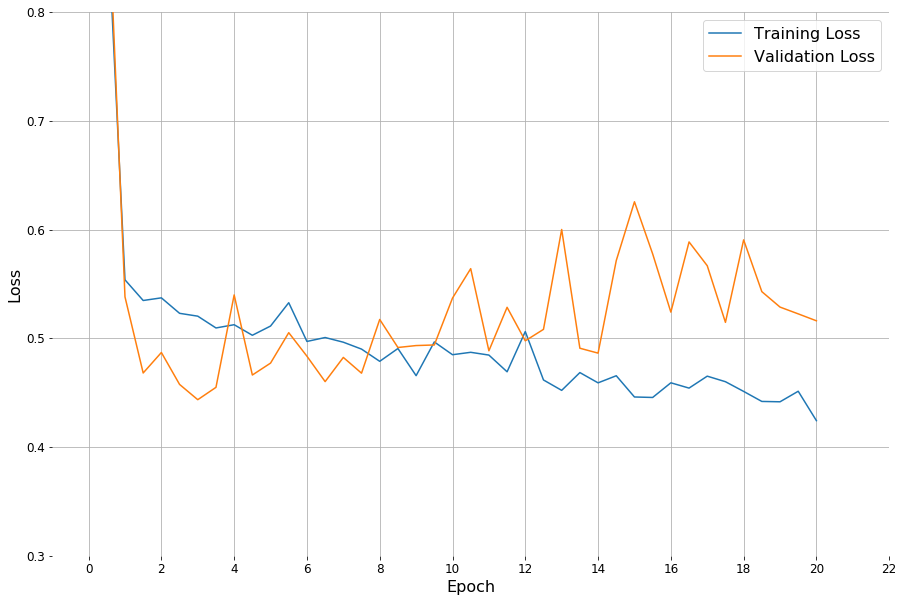

In [4]:
import math
with open( os.path.join(work_dir, 'TRAIN_LOSS.txt' ), 'r') as f:
    train_loss = list(map(float,  f.readlines()[0].split() )) 
    
with open( os.path.join(work_dir, 'VALIDATION_LOSS.txt' ), 'r') as f:
    validation_loss =list(map(float,  f.readlines()[0].split() )) 
    
log_per_epoch = 2
epochs = math.ceil(len(train_loss)/log_per_epoch)
x = np.arange(0, epochs + 1/log_per_epoch , 1/log_per_epoch)[0:len(train_loss)]


fig, ax = plt.subplots(figsize=(15,10))

ax.plot(x, train_loss, label='Training Loss')
ax.plot(x, validation_loss, label='Validation Loss')
#plt.ylim((0,1.5))
plt.ylim((0.3,0.8))
plt.xticks( np.arange(0, epochs +2, 2), fontsize=12 )
plt.yticks( fontsize=12)
ax.legend(fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid()

In [5]:
model = ResNet(image_channels=4, num_classes=9)
model.cuda()
model.load_state_dict(torch.load(os.path.join(work_dir, 'model_best.pth.tar'))['state_dict'])
#model = model.eval()


<All keys matched successfully>

In [6]:
def pred_absolutute(pred):
    if pred > 0.5:
        return 1
    else:
        return 0
    
def torch_pred_to_np(predictions):
    predictions_new = []
    predictions = list(predictions)
    for prediction in predictions:
        prediction_new = list(map( lambda p: float(p) ,prediction))
        predictions_new.append(prediction_new)
    return predictions_new

In [7]:
import matplotlib.patches as patches
def show_im_with_grid_labels(im, grid, grid_shape, grid_gt=None, T = 0.5):
    print('show_im_with_grid_labels',im.shape, grid.shape, grid_shape )
    fig,ax = plt.subplots(figsize=(10,10))
    grid_2d = grid.reshape(-1, grid_shape[1])
    if(grid_gt.any()):
        grid_2d_gt = grid_gt.reshape(-1, grid_shape[1])
    
    print(grid_2d)
    grid_w = im.shape[1]/grid_2d.shape[1]
    grid_h = im.shape[0]/grid_2d.shape[0]
    
    ax.imshow(im[:,:,-1], cmap='gray')
    
    #Draw Grid
    for x in range(grid_shape[1]):
        for y in range(grid_shape[0]):
            rect = patches.Rectangle((x*grid_w,y*grid_h),grid_w,grid_h,linewidth=2,edgecolor='white',facecolor='none')      
            ax.add_patch(rect)
    
    #Draw ground truth
    if grid_gt.any():
        for x in range(grid_shape[1]):
            for y in range(grid_shape[0]):

                if grid_2d_gt[y,x] > 0:
                    rect = patches.Rectangle((x*grid_w,y*grid_h),grid_w,grid_h,linewidth=5,edgecolor='green',facecolor='none', hatch='/')  
                    ax.add_patch(rect)
                
    
    #draw prediction
    for x in range(grid_shape[1]):
        for y in range(grid_shape[0]):              
                
            if grid_2d[y,x] > T:
                rect = patches.Rectangle((x*grid_w,y*grid_h),grid_w,grid_h,linewidth=4,edgecolor='red', ls='--', facecolor='none', hatch='\\' )  
                ax.add_patch(rect)
            ax.text(x*grid_w + grid_w/2 ,y*grid_h+ grid_h/2,
                        str(grid_2d[y,x])[:4],
                       horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=20, color='red')
            
    plt.draw()
    plt.show()

In [8]:
dataloader_train, dataloader_val = load_sheep_grid_data(batch_size, visOnly = False)

In [9]:
all_pred_val = []
all_gt_val = []

#with open(os.path.join(work_dir,"validation_predictions.txt"), "w") as file:
#            file.write("")


for batch_it, (X_batch, Y_batch, key_batch) in enumerate(dataloader_val):

    predictions = model(X_batch.cuda())    
    predictions = torch.sigmoid(predictions)
    predictions = torch_pred_to_np(predictions)
    ims = np.array(X_batch.permute(0,2,3,1)).astype(int)
    
    for i in range(batch_size):
        key = key_batch[i]
        prediction = predictions[i]
        #print(np.array(prediction))
        #print(np.array(Y_batch[i]))
        #print()
        all_pred_val = [*all_pred_val, *prediction]
        all_gt_val = [*all_gt_val, *list(Y_batch[i])]
        #show_im_with_grid_labels(ims[i,:,:,:], np.array(predictions[i]), (3,3), grid_gt=np.array(Y_batch[i]) , T=0.4)
        #with open(os.path.join(work_dir,"validation_predictions.txt"), "a") as file:
        #    file.write("{} {}\n".format(key, str(np.array(prediction))[1:-1]))
        


In [10]:
def count_TPs_FPs_TNs_FNs(all_pred, all_gt, T=0.5):

    TPs  = 0
    FPs = 0
    TNs = 0
    FNs = 0


    for i in range(len(all_gt)):
        pred = all_pred[i]
        if pred >= T:
            pred = 1
        else:
            pred = 0
        gt = all_gt[i]

        if pred == gt:
            if pred == 1:
                TPs = TPs +1

            if pred == 0:
                TNs = TNs +1
        else:
            if pred ==1:
                FPs = FPs +1
            if pred == 0:
                FNs = FNs +1

    precision = TPs / (TPs + FPs)
    recall = TPs / (TPs + FNs)
        
    return {
        'TPs': TPs,
        'FPs': FPs,
        'TNs': TNs,
        'FNs': FNs,
        'precision': precision,
        'recall': recall,
    }

In [15]:
res = count_TPs_FPs_TNs_FNs(all_pred_val, all_gt_val, T = 0.4)

ground_truth_count = res['TPs'] + res['FNs']
grid_cell_count = len(all_pred_val)
background_count = len(all_pred_val) - ground_truth_count

# If random:
Expected_TP = Expected_FN = ground_truth_count/2
Expected_FP =Expected_TN = background_count/2
Expected_Precision = Expected_TP / (Expected_TP + Expected_FP)
Expected_Recall = Expected_TP / ground_truth_count

print('precision: ', res['precision'] , '\t E(precision): ', Expected_Precision)
print('recall: ', res['recall'] , '\t E(recall): ', Expected_Recall)

print()
print(res)


precision:  0.5201465201465202 	 E(precision):  0.21851851851851853
recall:  0.6016949152542372 	 E(recall):  0.5

{'TPs': 142, 'FPs': 131, 'TNs': 713, 'FNs': 94, 'precision': 0.5201465201465202, 'recall': 0.6016949152542372}


In [13]:
#with open(os.path.join(work_dir,"train_predictions.txt"), "w") as file:
#            file.write("")
all_pred = []
all_gt = []

for batch_it, (X_batch, Y_batch, key_batch) in enumerate(dataloader_train):

    predictions = model(X_batch.cuda())
    predictions = torch.sigmoid(predictions)
    predictions = torch_pred_to_np(predictions)

    predictions

    ims = np.array(X_batch.permute(0,2,3,1)).astype(int)
    
    for i in range(len(predictions)):
        key = key_batch[i]
        prediction = predictions[i]
        
        all_pred = [*all_pred, *prediction]
        all_gt = [*all_gt, *list(Y_batch[i])]

        
        #show_im_with_grid_labels(ims[i,:,:,:], np.array(predictions[i]), (3,3), grid_gt=np.array(Y_batch[i]),T=0.4 )
        
#        with open(os.path.join(work_dir,"train_predictions.txt"), "a") as file:
#            file.write("{} {}\n".format(key, str(np.array(prediction))[1:-1]))
    

In [18]:
count_TPs_FPs_TNs_FNs(all_pred, all_gt, T = 0.31)

{'TPs': 907,
 'FPs': 893,
 'TNs': 1956,
 'FNs': 438,
 'precision': 0.5038888888888889,
 'recall': 0.6743494423791822}

show_im_with_grid_labels (2400, 2400, 3) (9,) (3, 3)
[[0 0 0]
 [0 1 0]
 [0 0 0]]


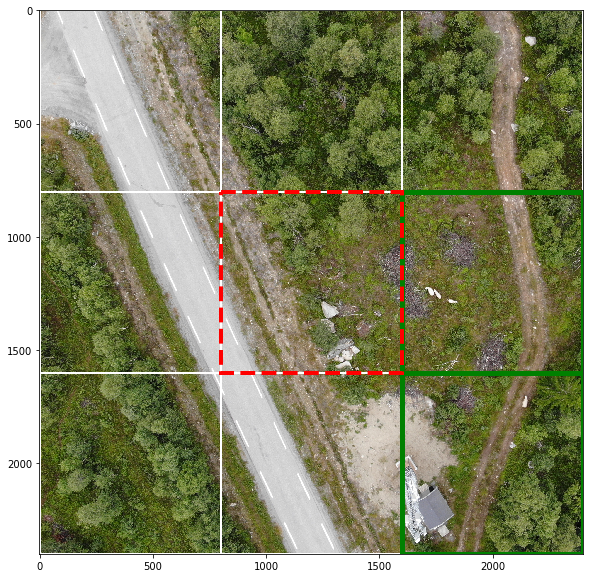

In [19]:

ground_truth_path = './data/data_external/annotations/val_grid_3_3.txt'
model

ResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin